In [0]:
# Library Dependencies

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import os
import shutil
import time
import re
import sys
import skimage.io as io

import random

from operator import itemgetter

from PIL import Image
from sklearn.metrics import jaccard_similarity_score

from torchvision import datasets, models, transforms

In [0]:
#constants
#the fraction of an image
#the object must occupy in order to 
#be considered prominent
#we extract images with one very prominent object
#and other possible smaller objects
PROMINENT_PERCENT_THRESHOLD = 0.3
OTHER_OBJ_THRESH = 0.1

MAX_PERCENT = 0.9

IMG_SIZE = 224

MAX_PROMINENT_NUM = 4

In [5]:
# Download and Install COCO API

!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/api

Cloning into 'cocoapi'...
remote: Enumerating objects: 947, done.
remote: Total 947 (delta 0), reused 0 (delta 0), pack-reused 947
Receiving objects: 100% (947/947), 11.69 MiB | 351.00 KiB/s, done.
Resolving deltas: 100% (565/565), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-package

In [0]:
# Download and Unzip Dataset 

!rm -rf /coco
!mkdir /coco
!rm /content/train.zip
!rm /content/annotations.zip

!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip -d /coco
!mv /coco/train2014 /coco/train
!rm /content/train2014.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip -d /coco 
!rm /content/annotations_trainval2014.zip

In [6]:
# Download and Unzip Validation 2017 Dataset 

!rm -rf /coco
!mkdir /coco
!rm /content/val.zip
!rm /content/annotations.zip

!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip -d /coco
!mv /coco/val2017 /coco/val
!rm /content/val2017.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d /coco 
!rm /content/annotations_trainval2017.zip

rm: cannot remove '/content/val.zip': No such file or directory
rm: cannot remove '/content/annotations.zip': No such file or directory
--2019-03-17 10:55:46--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.10.203
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.10.203|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  36.6MB/s    in 22s     

2019-03-17 10:56:08 (35.6 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

Archive:  val2017.zip
   creating: /coco/val2017/
 extracting: /coco/val2017/000000212226.jpg  
 extracting: /coco/val2017/000000231527.jpg  
 extracting: /coco/val2017/000000578922.jpg  
 extracting: /coco/val2017/000000062808.jpg  
 extracting: /coco/val2017/000000119038.jpg  
 extracting: /coco/val2017/000000114871.jpg  
 extracting: /coco/val2

In [0]:
import pycocotools

In [0]:
!mv /coco /content/coco

In [19]:
cocoData = torchvision.datasets.CocoDetection("/content/coco/val","/content/coco/annotations/instances_val2017.json", 
                                             transforms.ToTensor())
                                           

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


(-0.5, 351.5, 229.5, -0.5)

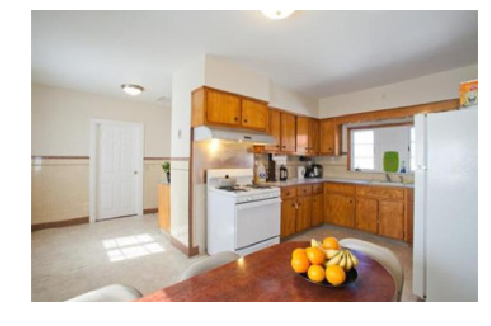

In [20]:
#visualize 1 image
datapoint = cocoData[1]
image, target = datapoint
#print(image.shape)
img = np.transpose(image, [1,2,0])
#print(target)

plt.imshow(img); plt.axis('off')
#cocoData.coco.showAnns(target)

In [21]:
#print categories in the supercategories of interest
cats = (cocoData.coco).loadCats((cocoData.coco).getCatIds())

for cat in cats:
  if (cat['supercategory'] == 'person' or cat['supercategory']=='vehicle' or cat['supercategory']=='animal'):
    print(cat['name'])
  #print("Super Catergories: ")
  #print(cat['supercategory'])
 

person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe


In [0]:
#returns the img dictionary and corresponding annotation id dictionary 
#containing images of
#the classes of interest (string sepcification, not id)
def generateSelImgDict(coco, interestSuperCats):
  #all categories
  #cats = coco.loadCats(coco.getCatIds())
  
  #category id's for the super categories of interest
  interestCatIds = coco.getCatIds(supNms = interestSuperCats)
  
  #the categories ids interest
  #they have a sueprcategory of 
  #person, vehicle or animal
  catIds_ = []
  imgIds = []
  annIds = []
  annDict = []
  
  #for all categories of interest, extract images with at least one of the 
  #categories in them
  for catId in interestCatIds:
        #catId = cocoData.coco.getCatIds(catNms = cat['name'])
        
        #get all images with at least this category in it
        imgIdVec = (cocoData.coco).getImgIds(catIds=catId)
        
        #for each image, add them to the id list
        #along with its annotations - this will allow easier access later on
        for item in imgIdVec:
          imgIds.append(item)
          
          #the ids for the annotation for this image, but only for the categories of
          #interest
          annId = cocoData.coco.getAnnIds(imgIds = item, catIds=interestCatIds, iscrowd=None)
          annDict.append(cocoData.coco.loadAnns(annId))

  #create dictionary of images of interest
  imgDict = (cocoData.coco).loadImgs(imgIds)
  
  return imgDict,annDict


In [0]:
supCatInterest = ['person', 'vehicle', 'animal']

In [0]:
#create the image and annotation dictionaries from the data
imgDict,annDict = generateSelImgDict(cocoData.coco, supCatInterest)

In [16]:
print(len(annDict))

5440


Height is: 480, Width is: 640


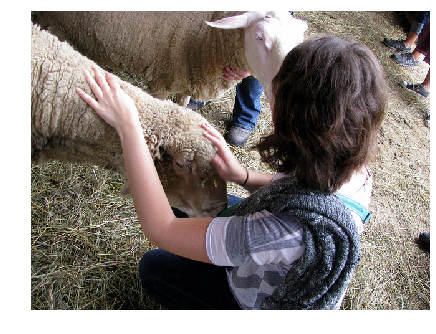

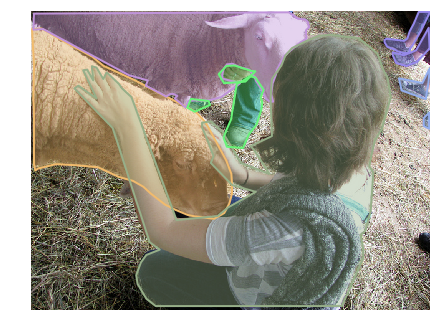

In [28]:
#Code adapted from:
#https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
#example image from those chosen

#example image
imgInd = 1

img  = imgDict[imgInd]
print("Height is: {}, Width is: {}".format(img['height'], img['width']))
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

#mask of image
plt.imshow(I); 
plt.axis('off')
#catIds = cocoData.coco.getCatIds(catNms= ['person', 'bus', 'bird', 'elephant'])
#annsId = cocoData.coco.getAnnIds(imgIds = img['id'], catIds = catIds, iscrowd = None)
#anns = cocoData.coco.loadAnns(annsId)
cocoData.coco.showAnns(annDict[imgInd])

(-0.5, 639.5, 479.5, -0.5)

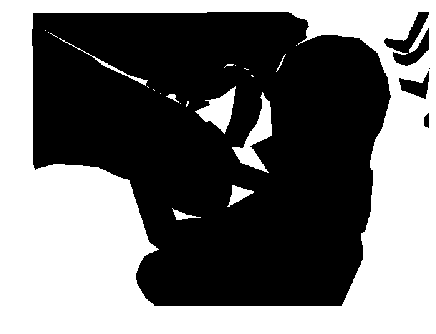

In [29]:
#bit mask for objects in image
#(objects of the category of interest)
anns = annDict[imgInd]
mask = cocoData.coco.annToMask(anns[0])

#create conglomerate mask over all objects in image
for i in range(len(anns)):
  mask = mask | cocoData.coco.annToMask(anns[i])

plt.imshow(mask); plt.axis('off')

In [0]:
print(mask)
mask_ = np.array(mask, dtype = 'float64')
print(mask_)

In [0]:
#extract masked objects
#returns modified image
def extractWithMask(img,mask):
  mask_ = np.array(mask)
  
  #reshape to give 3rd axis for broadcasting
  #to the 3 channels
  mask_ = np.expand_dims(mask_, axis = 2)
  img_ = np.array(img)
  
  modified_image = img_*mask_
  
  return modified_image

(-0.5, 639.5, 479.5, -0.5)

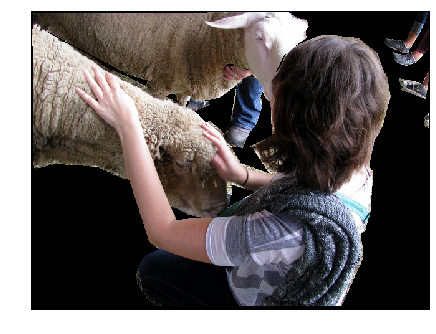

In [31]:
modified_img = extractWithMask(I, mask)
plt.imshow(modified_img)
plt.axis('off')

In [0]:
#given a single object's mask
#finds the percent of image that
#object occupies
def getPercentMask(obj_mask):
  num_occ= 0.0
  num_occ += (obj_mask != 0).sum()
  num_tot = sum(len(item) for item in obj_mask)
  
  return num_occ/num_tot


In [0]:
#given annotations for object
#creates a mask of only up to 4 prominent objects
#in the image
def genBinaryProminentMask(anns):
  mask = np.zeros(np.array(cocoData.coco.annToMask(anns[0])).shape)
  masks = []
  count = 0
  
  #order the annotations by percentage mask
  for i in range(len(anns)):
    obj_mask = cocoData.coco.annToMask(anns[i])
    percent = getPercentMask(obj_mask)
    masks.append((percent, obj_mask))
    
  #sort by percentage occupied
  masks.sort(key = itemgetter(0), reverse = True)
  
  #check if there exists a prominent object
  largest = masks[0][0]
  #print(largest)
  #return the empty mask if not prominent objects
  if(largest < PROMINENT_PERCENT_THRESHOLD):
    #print("Not large enough!")
    return mask
  
  #extract only the relevant masks
  #since we have at least 1 prominent objects
  #there can be smaller auxilary objects
  masks_filtered = [mask_[1] for mask_ in masks if mask_[0]>= OTHER_OBJ_THRESH]
    
  for i in range(len(masks_filtered)):
    if (count == MAX_PROMINENT_NUM):
      break
    
    mask += masks_filtered[i]
    count+=1
  
  #clip to form a binary mask
  mask = np.clip(mask, a_min = 0, a_max = 1)
  
  #count overall percentage
  #we want images which have some background
  all_percent = getPercentMask(mask)
  
  #if its too large, zero out mask
  if (all_percent > MAX_PERCENT):
    return mask*0
  
  return mask

(-0.5, 639.5, 479.5, -0.5)

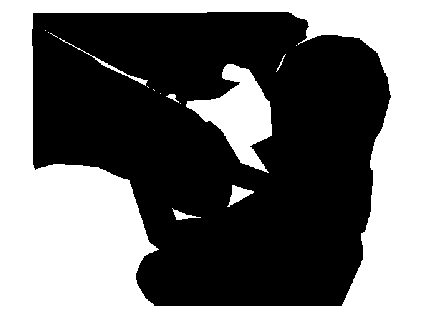

In [35]:
#test the code above on the img before
#only the man's object should be extracted in the mask now
mask_modified = genBinaryProminentMask(annDict[imgInd])
#print(mask_modified)
plt.imshow(mask_modified); plt.axis('off')

In [0]:
#given an img, crops and resizes it
#to be resize_dim by resize_dim
#fixes aspect ratio by padding to square
def crop_resize_square(img, mask, resize_dim=224):
  img = np.array(img)
  mask = np.array(mask)
  
  #turn img into a PIL img
  im_pil = Image.fromarray(img, 'RGB')
  mask_im = Image.fromarray(np.uint8(255*mask)) 

  #to make square, choose dimension for padding first
  #side_len = max(height, width, resize_dim)
  
  #maintain aspect ratio and reduce to a dimension of resize_dim
  size = (resize_dim, resize_dim)
  
  im = im_pil.copy()
  msk = mask_im.copy()
  
  #copy image and corresponding mask into lower size
  im.thumbnail(size,Image.ANTIALIAS)
  msk.thumbnail(size, Image.ANTIALIAS)
  
  w,h = im.size
  
  #create new image with black background
  square_im = Image.new('RGB', (resize_dim, resize_dim), (0,0,0))
  square_msk = Image.new('1', (resize_dim, resize_dim))#, (0,0,0))
  
  #paste in the original image to the square shaped one
  square_im.paste(im, (int((resize_dim-w)/2), int((resize_dim-h)/2)))
  square_msk.paste(msk, (int((resize_dim-w)/2), int((resize_dim-h)/2)))
  
  sq_msk_np = np.array(square_msk)
  sq_msk_np = np.clip(sq_msk_np, a_min=0, a_max=1)
  
  
  return np.array(square_im), sq_msk_np

#does not care for aspect ratio
#only resizes image to square
def resize_square(img, mask, resize_dim = 224):
  img = np.array(img)
  mask = np.array(mask)
  
  #turn img into a PIL img
  im_pil = Image.fromarray(img, 'RGB')
  mask_im = Image.fromarray(np.uint8(255*mask)) 

  size = (resize_dim, resize_dim)
  im_pil= im_pil.resize(size, Image.ANTIALIAS)
  mask_im=mask_im.resize(size, Image.ANTIALIAS)
  
  mask_im_np = np.array(mask_im)
  mask_im_np = np.clip(mask_im_np, a_min=0, a_max=1)
  
  return np.array(im_pil), mask_im_np

(-0.5, 223.5, 223.5, -0.5)

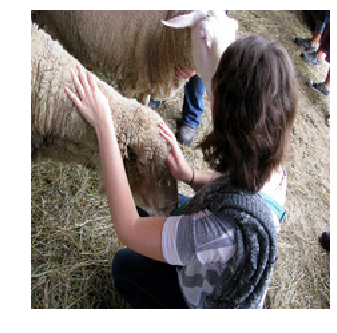

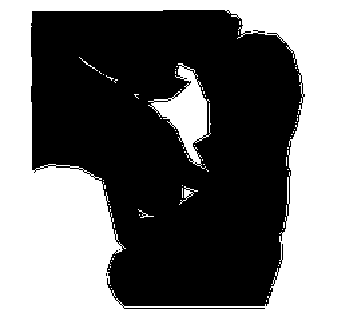

In [40]:
#with resizing
im,msk =resize_square(I, mask_modified)

plt.figure()
plt.imshow(im); plt.axis('off')

plt.figure()
plt.imshow(msk); plt.axis('off')


In [0]:
#with padding, maintain aspect ratio
im,msk =crop_resize_square(I, mask_modified)
plt.figure()
plt.imshow(im); plt.axis('off')

plt.figure()
plt.imshow(msk); plt.axis('off')

plt.figure()
plt.imshow(extractWithMask(im, msk)); plt.axis('off')

plt.figure()
tensor = torch.from_numpy(im)
mask = torch.from_numpy(msk)
plt.imshow(tensor); plt.axis('off')

In [0]:
#given the img and annotation dictionaries
#removes and cleans the data
#so that only those images with
#prominent objects remain

#returns the cleaned images, and their masks
#as targets in a tuple called data

#returns a numpy array for image and mask
def data_parse_prominent(imgDict, annDict, size, just_resize = False, 
                         crop = True, toTensor = False, path = "None"):
  transforms_ = transforms.Compose([
      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])
  data = []
  
  count = 0
  
  #randomly shuffle indices to 
  #acces different images
  ind = np.arange(len(imgDict))
  #random.shuffle(ind)
  
  for i in ind:
    
    #stop when size is reached
    if(count == size):
      break
      
    #generate prominent mask for object:
    mask = genBinaryProminentMask(annDict[i])
    
    #if entire mask is 0
    #there were no prominent objects in the mask
    #we only wish to add prominent objects
    if np.sum(mask)!=0:
      imgInf = imgDict[i]
      img = np.array(io.imread(imgInf['coco_url']))
     
      if(just_resize == True):
        img,mask = resize_square(img,mask)
      elif (crop==True):
        img,mask = crop_resize_square(img, mask)
      
      if (toTensor == True):
        #transpose to [C,H,W] format for convolution
        img = torch.from_numpy(np.transpose(img, [2,0,1]))
        img = transforms_(img.float())
        
        mask = torch.from_numpy(mask).unsqueeze(0)
        mask = mask.float()
      
      data.append((img, mask))
      count+=1
      
  if (count != size):
    print("Not enough data for size requested")
    
  return data

In [0]:
print(len(imgDict))

5440


In [0]:
data = data_parse_prominent(imgDict, annDict,20, toTensor = True)

In [0]:
data = data_parse_prominent(imgDict, annDict, 20)

In [250]:
print(len(data))

20


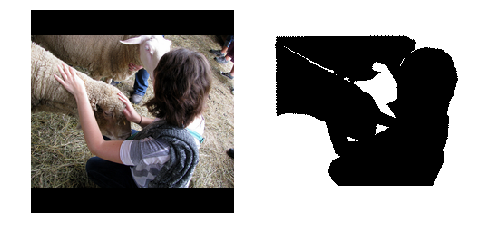

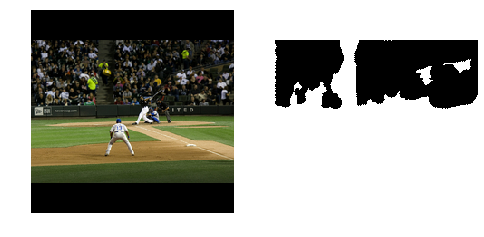

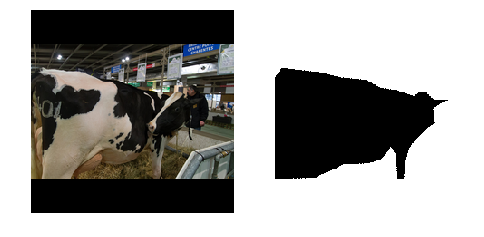

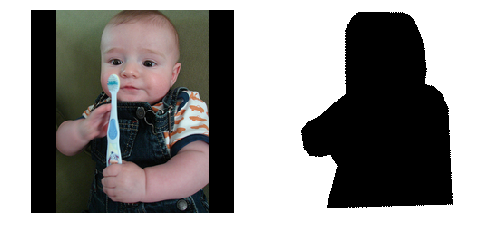

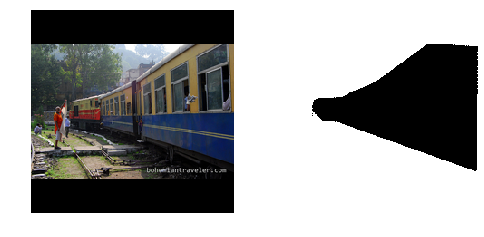

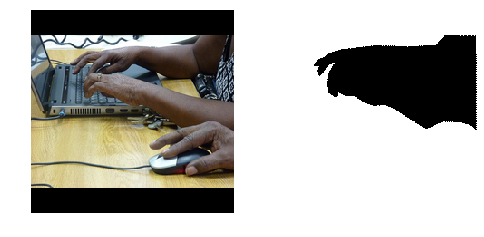

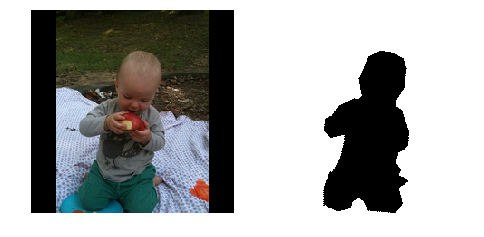

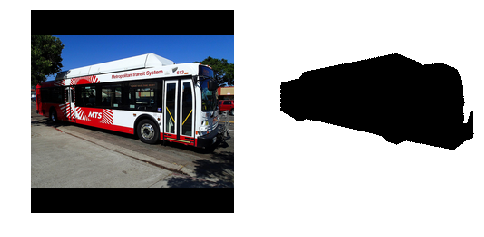

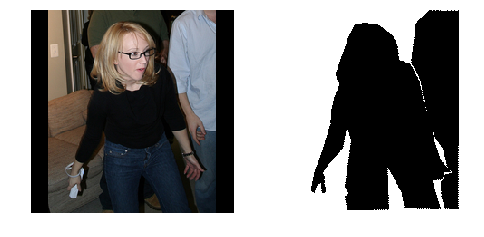

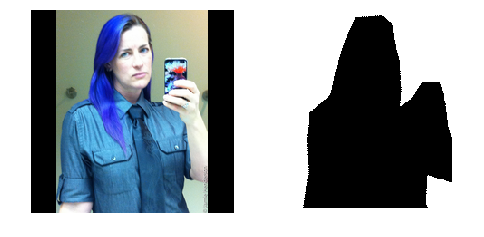

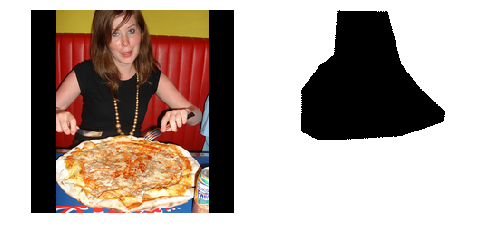

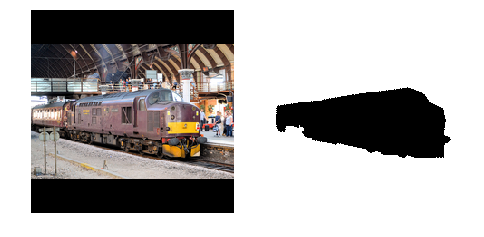

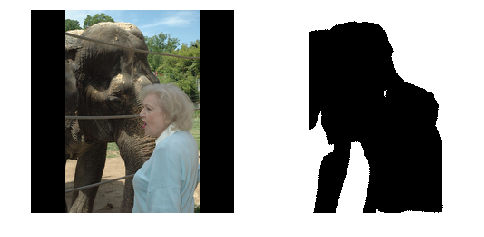

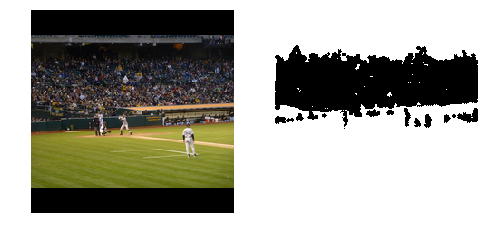

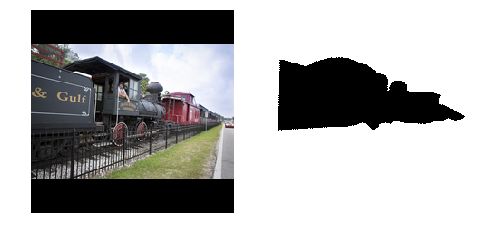

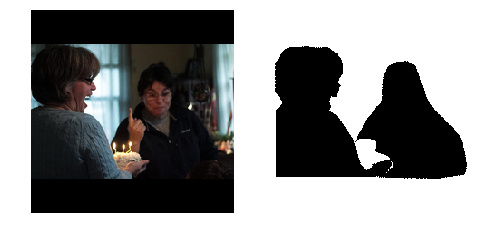

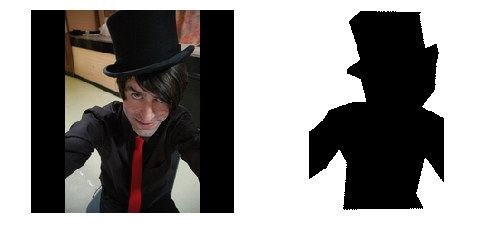

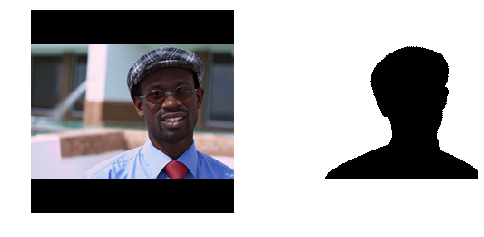

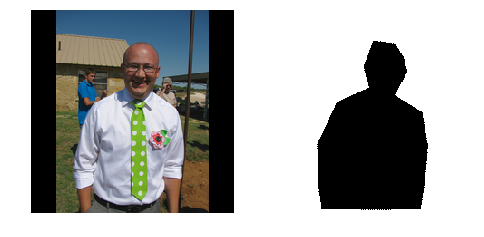

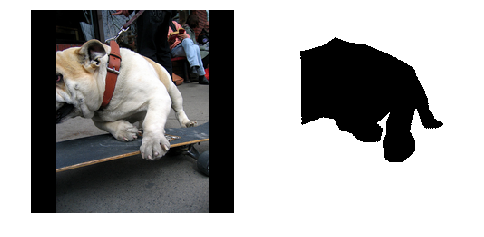

In [296]:
#visualization of data
for i,datapt in enumerate(data2):
  img, target = datapt
  
 # print("Image: {}".format(i))
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(img);   plt.axis('off')
  
  plt.subplot(1,2,2)
  plt.imshow(target); plt.axis('off')
  
plt.show()

In [0]:
data_loader =  torch.utils.data.DataLoader(data,
                                          batch_size=4,
                                          shuffle=True)

In [570]:
for i, data in enumerate(data_loader):
  if (i>10):
    break
    
  img, target = data
  print(img.shape)
  print(target.shape)
  

RuntimeError: ignored

In [0]:
#create small dataset for training and validation
dataset = data_parse_prominent(imgDict, annDict,50, just_resize =True,
                               toTensor=True)
train = dataset[:40]
valid = dataset[40:]

In [0]:
train_loader2 = torch.utils.data.DataLoader(train,
                                          batch_size=32,
                                          shuffle=False)

In [0]:
class extractNet_simple(nn.Module):
  
  def __init__(self):
    super(extractNet_simple, self).__init__()
    self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
    )
    self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
     )
  def forward(self, img):
        out = self.encoder(img)
        out = self.decoder(out)
        return out
  

In [0]:
net = extractNet_simple()

In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

Loss is:  tensor(0.2371, grad_fn=<BinaryCrossEntropyBackward>)
So far:  0
Loss is:  tensor(0.2346, grad_fn=<BinaryCrossEntropyBackward>)
So far:  1
Loss is:  tensor(0.2320, grad_fn=<BinaryCrossEntropyBackward>)
So far:  2
Loss is:  tensor(0.2301, grad_fn=<BinaryCrossEntropyBackward>)
So far:  3
Loss is:  tensor(0.2272, grad_fn=<BinaryCrossEntropyBackward>)
So far:  4
Loss is:  tensor(0.2233, grad_fn=<BinaryCrossEntropyBackward>)
So far:  5
Loss is:  tensor(0.2188, grad_fn=<BinaryCrossEntropyBackward>)
So far:  6
Loss is:  tensor(0.2141, grad_fn=<BinaryCrossEntropyBackward>)
So far:  7
Loss is:  tensor(0.2088, grad_fn=<BinaryCrossEntropyBackward>)
So far:  8
Loss is:  tensor(0.2030, grad_fn=<BinaryCrossEntropyBackward>)
So far:  9
Loss is:  tensor(0.1967, grad_fn=<BinaryCrossEntropyBackward>)
So far:  10
Loss is:  tensor(0.1901, grad_fn=<BinaryCrossEntropyBackward>)
So far:  11
Loss is:  tensor(0.1830, grad_fn=<BinaryCrossEntropyBackward>)
So far:  12
Loss is:  tensor(0.1754, grad_fn=<B

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss is:  tensor(0.0005, grad_fn=<BinaryCrossEntropyBackward>)
So far:  999


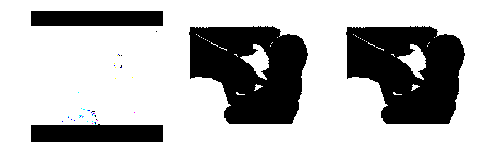

In [501]:
max_j = 999

for j in range(max_j+1):
  for i, data in enumerate(train_loader):
    if (i>0):
      break
    
    img, target = data
    out = net(img[0].unsqueeze(0))
    loss = criterion(out[0], target[0])
    loss.backward() 
    optimizer.step()
    optimizer.zero_grad()
    
    if(j == max_j):
      plt.figure()
      plt.subplot(1,3,1)
      plt.imshow(to_np_img(img[0]));   plt.axis('off')
  
      plt.subplot(1,3,2)
      plt.imshow(to_np_img(target[0])); plt.axis('off')
  
      plt.subplot(1,3,3)
      generatedMask = threshold_prob_mask(to_np_img(out[0]))
  
  
      plt.imshow(generatedMask); plt.axis('off')

    print("Loss is: ", loss)
  
  
  print("So far: ", j)
 

In [0]:
def visualize(model, img, target):
  plt.figure()
  plt.subplot(1,3,1)
  plt.imshow(to_np_img(img, 'img'));   plt.axis('off')
  
  plt.subplot(1,3,2)
  plt.imshow(to_np_img(target)); plt.axis('off')
  
  res = model(img.unsqueeze(0).float())
  print(res.shape)
  
  plt.subplot(1,3,3)
  generatedMask = threshold_prob_mask(to_np_img(res.squeeze(0)))
  plt.imshow(generatedMask); plt.axis('off')


  print("IoU: ", single_iou(res, target))

In [44]:
img, target = train[0]
visualize(net,img, target)

NameError: ignored

In [0]:
#given a tensor of images, converts to numpy images
#assumes tensor image is in format NCHW
def to_np_img(tensor_img, type_ = 'mask'):
  image = tensor_img.detach().numpy()
  
    #renormalize for imshow plotting
  if(type_ != 'mask'):
    image = image/255
  
  #print("This dimensions is: ", image.shape)
  image = np.transpose(image, [1,2,0])
  return image.squeeze()

def threshold_prob_mask(prob_mask):
  prob_mask[prob_mask>0.5] = 1
  prob_mask[prob_mask<=0.5] = 0
  return prob_mask

In [0]:
#for computing the accuracy metric: IoU
#from the target and predicted masks
def single_iou(pred, target):
  true_mask = target.squeeze(1).detach().numpy()
  pred_mask = pred.squeeze(1).detach().numpy()
  
  #print("True: ", true_mask.shape)
  #print("Gen: ", pred_mask.shape)
  
  
  intersect = np.sum((true_mask*pred_mask), axis=(1,2)) 
  union = np.sum(np.clip(true_mask + pred_mask, a_min =0,a_max=1), axis= (1,2))
  
  #if (np.sum(intersect)==0):
  # print("0 Intersect!")
  #tensor of iou for each image
  iou = intersect/union
  
  #sum iou over all images in batch
  return np.sum(iou)


def get_iou(model, data):
  data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=4,
                                          shuffle=False)
    
    
  total_iou = 0
  num_data = 0
    
  for i, batch in enumerate(data_loader):
      img, target = batch
      pred = model(img)
      iou = single_iou(pred, target)
      total_iou = iou+total_iou
      
      num_data += img.shape[0]
       
  #average iou on data set  
  return total_iou/num_data


In [0]:
#training helper functions
#generates name for saving from hyperparameters
def model_name(lr, batch_size):
    return "en_model_lr={}_bs={}".format(
        lr,batch_size)

#computes average loss 
#over dataset
def get_loss(model, data, criterion):
    data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=4,
                                          shuffle=False)
    
    total_loss = 0
    num_data = 0
    
    for i, batch in enumerate(data_loader):
        img, target = batch
        pred = model(img)
        loss = criterion(pred, target)
        total_loss += loss
        num_data += img.shape[0]
        
    return total_loss/num_data

#plots curve for given train and validation arrays
#ctype is either "Accuracy" or "Loss" depending on which values are
#passed
def plot_curve(train_val, valid_val, num_epochs, ctype):
    plt.title("Train vs Validation {}".format(ctype))
    plt.plot(range(num_epochs), train_val, label = "Train")
    plt.plot(range(num_epochs), valid_val, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel(ctype)
    plt.legend(loc = 'best')
    plt.show()

def plot_all(train_loss,valid_loss, train_acc, 
                 valid_acc, num_epochs):
        #plot loss curves
        plot_curve(train_loss, valid_loss, num_epochs, ctype = 'Loss')
        
        #plot accuracy curves
        plot_curve(train_acc, valid_acc, num_epochs, ctype = 'IoU') 


In [0]:
def train_model(model, train, valid, out_suppress= False,
                batch_size=32,
               lr = 0.001, num_epochs = 30):
    name = model_name(lr, batch_size)
    
    #arrays to track loss and accuracy
    #for plotting
    train_loss = np.zeros(num_epochs)
    valid_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    valid_acc = np.zeros(num_epochs)
    
    #BCE loss since this is a 
    #pixelwise binary classification
    #problem
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr = lr)
    
    #create bucket iterator to go over epochs
    #repeat = false so we stop after 1 epoch
    train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=batch_size,
                                          shuffle=True)
    
    for epoch in range(num_epochs):
        #for all batches in data
        for i,batch in enumerate(train_loader):
            #extract data sequences
            #and target masks
            img, target = batch
            
            #normalize image
            #img=  transforms_(img)
            
            optimizer.zero_grad()
            
            #forward pass
            pred = model(img)
            
            loss = criterion(pred, target)
            
            #backward pass
            loss.backward()
            
            #update weights
            optimizer.step()

        #keep track of accuracy and loss each epoch
        #training loss over the entire data set
        #is recalculated at the end of each epoch instead
        #of averaging over the minibatches above
        #so that it the same weight set is used
        #for each computation, and so
        # it is more comparable with validation
        #loss (which is also computes using the weights
        #at the end of the epoch)
        train_loss[epoch] = get_loss(model, train, criterion)
        train_acc[epoch] = get_iou(model, train)
        
        valid_loss[epoch]  =get_loss(model, valid, criterion)
        valid_acc[epoch] = get_iou(model, valid)
        
        #checkpoint model at current epoch
        torch.save(model.state_dict(), name+"epoch={}".format(epoch))
        
        #print out the training information
        if (out_suppress == False):
            print(("Epoch:{}, Train IoU:{:.4f}, Train Loss:{:.4f}"
                  +"|Valid IoU:{:.4f}, Valid Loss:{:.4f}").format(
            epoch, train_acc[epoch], train_loss[epoch],
            valid_acc[epoch], valid_loss[epoch]))
        
    #training end
    print("Training Finished")
    print("\nFinal Training IoU: ", train_acc[-1])
    print("\nBest Validation IoU: ", np.amax(valid_acc))
    print("Which occurs at epoch: ", np.argmax(valid_acc))
    
    #plot all curves
    if (out_suppress == False):
        plot_all(train_loss, valid_loss, train_acc, 
                 valid_acc, num_epochs)
        
    #save the loss and accuracies
    #in case needed for future plot/comparision
    np.savetxt("{}_train_loss.csv".format(name)
               , train_loss)
    np.savetxt("{}_val_loss.csv".format(name)
               , valid_loss)
    np.savetxt("{}_train_acc.csv".format(name)
               , train_acc)
    np.savetxt("{}_val_acc.csv".format(name)
               , valid_acc)

In [0]:
model2 = extractNet_simple()

torch.Size([1, 3, 224, 224])
IoU:  0.3533206


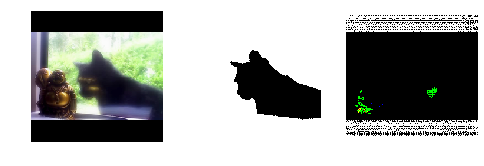

In [778]:
img, target = train[-12]
visualize(model2,img, target)

Epoch:0, Train Acc:0.2530, Train Loss:0.2365|Valid Acc:0.2468, Valid Loss:0.3229
Epoch:1, Train Acc:0.2764, Train Loss:0.2328|Valid Acc:0.2754, Valid Loss:0.3267
Epoch:2, Train Acc:0.2447, Train Loss:0.2156|Valid Acc:0.2393, Valid Loss:0.2828
Epoch:3, Train Acc:0.2487, Train Loss:0.2018|Valid Acc:0.2446, Valid Loss:0.2603
Epoch:4, Train Acc:0.2516, Train Loss:0.2000|Valid Acc:0.2485, Valid Loss:0.2583
Epoch:5, Train Acc:0.2510, Train Loss:0.1999|Valid Acc:0.2482, Valid Loss:0.2579
Epoch:6, Train Acc:0.2514, Train Loss:0.1998|Valid Acc:0.2488, Valid Loss:0.2575
Epoch:7, Train Acc:0.2524, Train Loss:0.1995|Valid Acc:0.2502, Valid Loss:0.2571
Epoch:8, Train Acc:0.2534, Train Loss:0.1992|Valid Acc:0.2516, Valid Loss:0.2567
Epoch:9, Train Acc:0.2539, Train Loss:0.1987|Valid Acc:0.2521, Valid Loss:0.2561
Epoch:10, Train Acc:0.2550, Train Loss:0.1980|Valid Acc:0.2530, Valid Loss:0.2556
Epoch:11, Train Acc:0.2570, Train Loss:0.1970|Valid Acc:0.2543, Valid Loss:0.2548
Epoch:12, Train Acc:0.2611

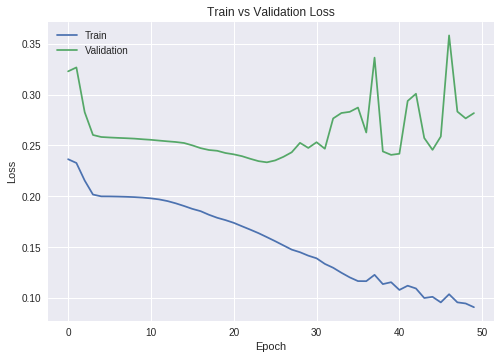

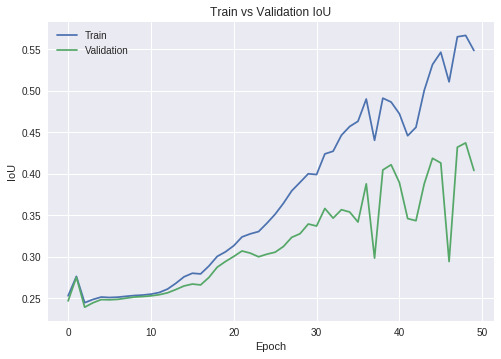

In [734]:
train_model(model2, train[:10], valid[:5], batch_size= 32, num_epochs= 50)

torch.Size([1, 1, 224, 224])
IoU:  0.31220463


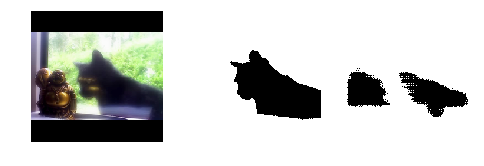

In [736]:
#after training
img, target = train[-12]
visualize(model2,img, target)

Epoch:0, Train Acc:0.4960, Train Loss:0.3280|Valid Acc:0.4460, Valid Loss:0.6424
Epoch:1, Train Acc:0.5370, Train Loss:0.1175|Valid Acc:0.4520, Valid Loss:0.2636
Epoch:2, Train Acc:0.3898, Train Loss:0.1416|Valid Acc:0.1740, Valid Loss:0.4716
Epoch:3, Train Acc:0.3859, Train Loss:0.1271|Valid Acc:0.2259, Valid Loss:0.3784
Epoch:4, Train Acc:0.3902, Train Loss:0.1211|Valid Acc:0.2773, Valid Loss:0.3178
Epoch:5, Train Acc:0.3936, Train Loss:0.1200|Valid Acc:0.3028, Valid Loss:0.2860
Epoch:6, Train Acc:0.3993, Train Loss:0.1198|Valid Acc:0.3199, Valid Loss:0.2669
Epoch:7, Train Acc:0.4071, Train Loss:0.1194|Valid Acc:0.3334, Valid Loss:0.2555
Epoch:8, Train Acc:0.4174, Train Loss:0.1185|Valid Acc:0.3450, Valid Loss:0.2492
Epoch:9, Train Acc:0.4287, Train Loss:0.1176|Valid Acc:0.3553, Valid Loss:0.2469
Epoch:10, Train Acc:0.4400, Train Loss:0.1169|Valid Acc:0.3635, Valid Loss:0.2483
Epoch:11, Train Acc:0.4502, Train Loss:0.1162|Valid Acc:0.3684, Valid Loss:0.2536
Epoch:12, Train Acc:0.4589

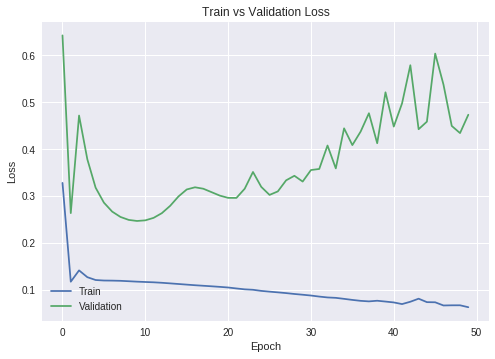

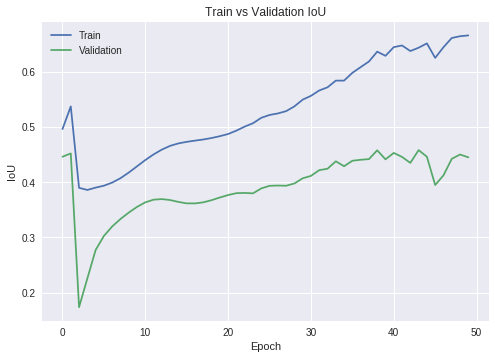

In [737]:
#train 50 more epochs
train_model(model2, train[:10], valid[:5], batch_size= 32, num_epochs= 50)

torch.Size([1, 1, 224, 224])
IoU:  0.6271891


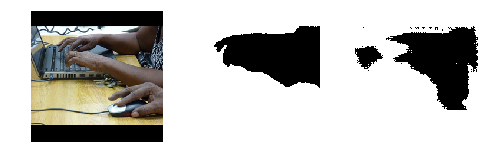

In [743]:
#after additional training
img, target = train[5]
visualize(model2,img, target)

In [0]:
#test model aboves performance on only person data set
supCatInterest = ['person']

#create the image and annotation dictionaries from the data
imgDict_p,annDict_p = generateSelImgDict(cocoData.coco, supCatInterest)

#create small dataset for training and validation
dataset_p = data_parse_prominent(imgDict_p, annDict_p,50, 
                                 just_resize= True,
                                 toTensor=True)

In [0]:
train_p = dataset_p[:40]
valid_p = dataset_p[40:]

In [0]:
model_p = extractNet_simple()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 224, 224])
IoU:  0.26207456


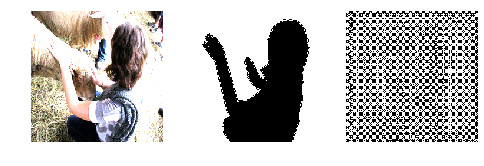

In [124]:
#initial evaluation
img, target = train_p[0]
visualize(model_p,img, target)

Epoch:0, Train IoU:0.2977, Train Loss:0.3398|Valid IoU:0.2966, Valid Loss:0.5445
Epoch:1, Train IoU:0.3276, Train Loss:0.6932|Valid IoU:0.3283, Valid Loss:1.1320
Epoch:2, Train IoU:0.3314, Train Loss:0.4816|Valid IoU:0.3283, Valid Loss:0.8289
Epoch:3, Train IoU:0.2947, Train Loss:0.4437|Valid IoU:0.2866, Valid Loss:0.6902
Epoch:4, Train IoU:0.3113, Train Loss:0.2855|Valid IoU:0.3051, Valid Loss:0.4047
Epoch:5, Train IoU:0.3227, Train Loss:0.2179|Valid IoU:0.3260, Valid Loss:0.2906
Epoch:6, Train IoU:0.3323, Train Loss:0.2078|Valid IoU:0.3290, Valid Loss:0.2778
Epoch:7, Train IoU:0.3305, Train Loss:0.2082|Valid IoU:0.3259, Valid Loss:0.2774
Epoch:8, Train IoU:0.3312, Train Loss:0.2103|Valid IoU:0.3272, Valid Loss:0.2826
Epoch:9, Train IoU:0.3305, Train Loss:0.2138|Valid IoU:0.3241, Valid Loss:0.2946
Epoch:10, Train IoU:0.3335, Train Loss:0.2092|Valid IoU:0.3277, Valid Loss:0.2823
Epoch:11, Train IoU:0.3343, Train Loss:0.2077|Valid IoU:0.3307, Valid Loss:0.2745
Epoch:12, Train IoU:0.3341

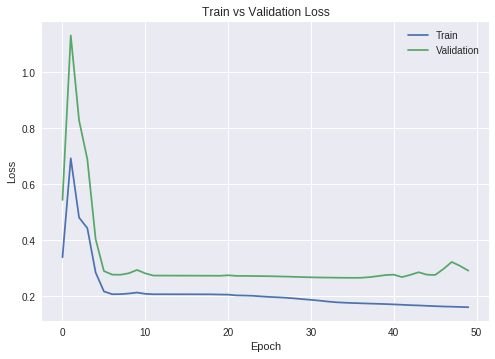

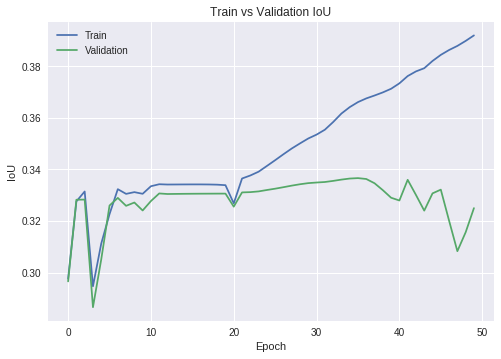

In [125]:
train_model(model_p, train_p[:10], valid_p[:5], batch_size= 32, lr = 1e-3, num_epochs= 50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 224, 224])
IoU:  0.5450878


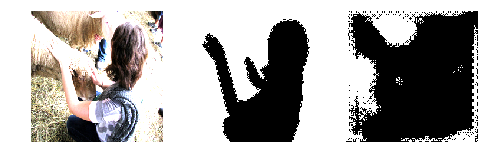

In [126]:
#after training
img, target = train_p[0]
visualize(model_p,img, target)

torch.Size([1, 1, 224, 224])
IoU:  0.5188015


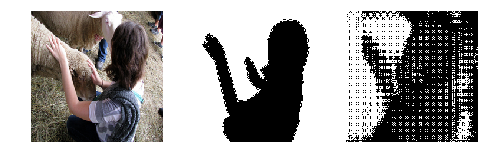

In [58]:
#after training
img, target = train_p[0]
visualize(model_p,img, target)

In [0]:
class extractNet_v2(nn.Module):
  
  def __init__(self):
    super(extractNet_v2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
    
    self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)

    self.conv3 = nn.Conv2d(32, 64, 7)
     
    self.deconv1 = nn.ConvTranspose2d(64, 32, 7)
    
    self.deconv2 = nn.ConvTranspose2d(32+32, 16, 3, stride=2, padding=1, output_padding=1)
    
           
    self.deconv3 = nn.ConvTranspose2d(16+16, 1, 3, stride=2, padding=1, output_padding=1)
     
  def forward(self, img):
    enc_out1 = F.relu(self.conv1(img))
    enc_out2= F.relu(self.conv2(enc_out1))
    enc_out3 = F.relu(self.conv3(enc_out2))
    
    out = F.relu(self.deconv1(enc_out3))
    
    out = torch.cat((out, enc_out2),1)
    out = F.relu(self.deconv2(out))
    
    out = torch.cat((out, enc_out1),1)
    out = self.deconv3(out)
    
    out = torch.sigmoid(out)
    
    return out

In [0]:
model = extractNet_v2()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 224, 224])
IoU:  0.3653052


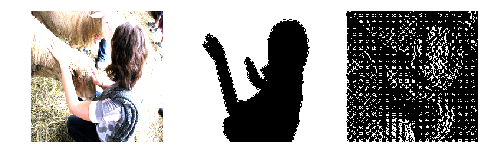

In [150]:
#before training
img, target = train_p[0]
visualize(model,img, target)

Epoch:0, Train IoU:0.4410, Train Loss:2.8465|Valid IoU:0.4557, Valid Loss:3.3559
Epoch:1, Train IoU:0.4270, Train Loss:2.6883|Valid IoU:0.4150, Valid Loss:3.1517
Epoch:2, Train IoU:0.4240, Train Loss:2.5651|Valid IoU:0.4147, Valid Loss:3.0425
Epoch:3, Train IoU:0.4291, Train Loss:2.4707|Valid IoU:0.4237, Valid Loss:2.9712
Epoch:4, Train IoU:0.4357, Train Loss:2.3705|Valid IoU:0.4195, Valid Loss:2.9112
Epoch:5, Train IoU:0.4287, Train Loss:2.2610|Valid IoU:0.4038, Valid Loss:2.8484
Epoch:6, Train IoU:0.4179, Train Loss:2.1613|Valid IoU:0.3849, Valid Loss:2.8366
Epoch:7, Train IoU:0.4302, Train Loss:2.0335|Valid IoU:0.3930, Valid Loss:2.6753
Epoch:8, Train IoU:0.4357, Train Loss:1.9268|Valid IoU:0.4000, Valid Loss:2.5842
Epoch:9, Train IoU:0.4231, Train Loss:1.7946|Valid IoU:0.3614, Valid Loss:2.6125
Epoch:10, Train IoU:0.4289, Train Loss:1.6968|Valid IoU:0.3543, Valid Loss:2.5407
Epoch:11, Train IoU:0.4265, Train Loss:1.5615|Valid IoU:0.3410, Valid Loss:2.5138
Epoch:12, Train IoU:0.4297

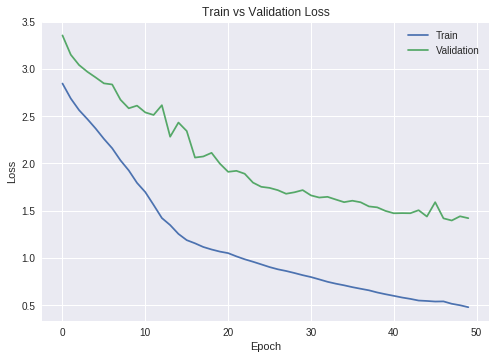

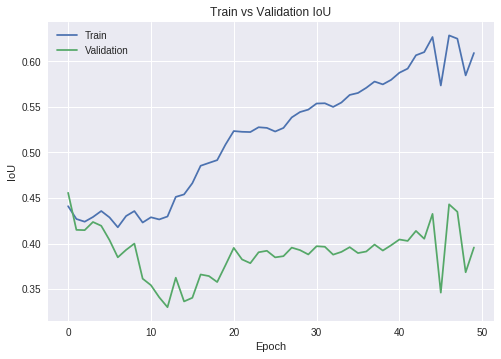

In [152]:
train_model(model, train_p[:10], valid_p[:5], batch_size= 32, lr = 1e-3, num_epochs= 50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 224, 224])
IoU:  0.5487954


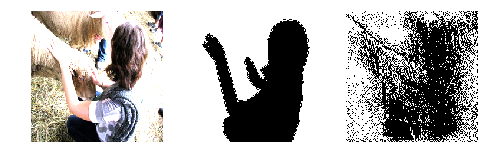

In [170]:
#after training
img, target = train_p[0]
visualize(model,img, target)